In [1]:
!pip install findspark

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Data Kecelakaan').getOrCreate()

df = spark.read.csv("UK_Accident.csv", header=True, inferSchema=True)
df.show(n=5, vertical=True,  truncate=False)


df.printSchema()
print("Jumlah baris:", df.count())
print("Jumlah kolom:", len(df.columns))

25/11/26 18:27:24 WARN Utils: Your hostname, ahmadyaa-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/11/26 18:27:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/26 18:27:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/26 18:27:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/11/26 18:27:27 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/11/26 18:27:40 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
25/11/26 18:27:44 

-RECORD 0----------------------------------------------------------------------------------
 _c0                                         | 0                                           
 Accident_Index                              | 200501BS00001                               
 Location_Easting_OSGR                       | 525680.0                                    
 Location_Northing_OSGR                      | 178240.0                                    
 Longitude                                   | -0.19117                                    
 Latitude                                    | 51.489096                                   
 Police_Force                                | 1                                           
 Accident_Severity                           | 2                                           
 Number_of_Vehicles                          | 1                                           
 Number_of_Casualties                        | 1                                

[Stage 3:============================================>              (6 + 2) / 8]

Jumlah baris: 1504150
Jumlah kolom: 33


In [3]:
from pyspark.sql.functions import col, count, desc

# Mencari mode kolom Pedestrian_Crossing-Human_Control
mode_pc_hc = (df.groupBy("Pedestrian_Crossing-Human_Control")
                .count()
                .orderBy(desc("count"))
                .first()[0])

df = df.fillna({"Pedestrian_Crossing-Human_Control": mode_pc_hc})

In [4]:
mode_pc_pf = (df.groupBy("Pedestrian_Crossing-Physical_Facilities")
                .count()
                .orderBy(desc("count"))
                .first()[0])

df = df.fillna({"Pedestrian_Crossing-Physical_Facilities": mode_pc_pf})

In [5]:
df = df.dropna(subset=["Time", "Longitude", "Location_Easting_OSGR"])

In [6]:
df = df.drop("LSOA_of_Accident_Location")

In [7]:
from pyspark.sql.functions import to_timestamp, concat_ws

df = df.withColumn("DateTime", to_timestamp(concat_ws(" ", "Date", "Time"), "dd/MM/yyyy HH:mm:ss"))
df = df.drop("Date", "Time")



In [8]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Weather_Conditions", outputCol="Weather_Indexed")
df = indexer.fit(df).transform(df)


In [9]:
from pyspark.sql.functions import col, sum

missing = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing.show(vertical=True, truncate=False)

25/11/26 18:28:26 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Accident_Index, Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Police_Force, Accident_Severity, Number_of_Vehicles, Number_of_Casualties, Date, Day_of_Week, Time, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit, Junction_Control, 2nd_Road_Class, 2nd_Road_Number, Light_Conditions, Weather_Conditions, Road_Surface_Conditions, Special_Conditions_at_Site, Carriageway_Hazards, Urban_or_Rural_Area, Did_Police_Officer_Attend_Scene_of_Accident, Year
 Schema: _c0, Accident_Index, Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Police_Force, Accident_Severity, Number_of_Vehicles, Number_of_Casualties, Date, Day_of_Week, Time, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit, Junction_Control, 2nd_Road_Class, 2nd_Road_Number, Light_Conditio

-RECORD 0----------------------------------------------
 _c0                                         | 0       
 Accident_Index                              | 0       
 Location_Easting_OSGR                       | 0       
 Location_Northing_OSGR                      | 0       
 Longitude                                   | 0       
 Latitude                                    | 0       
 Police_Force                                | 0       
 Accident_Severity                           | 0       
 Number_of_Vehicles                          | 0       
 Number_of_Casualties                        | 0       
 Day_of_Week                                 | 0       
 Local_Authority_(District)                  | 0       
 Local_Authority_(Highway)                   | 0       
 1st_Road_Class                              | 0       
 1st_Road_Number                             | 0       
 Road_Type                                   | 0       
 Speed_limit                                 | 0

In [10]:
df = df.drop("DateTime")

In [11]:
from pyspark.sql.functions import col, sum

missing = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing.show(vertical=True, truncate=False)

25/11/26 18:29:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Accident_Index, Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Police_Force, Accident_Severity, Number_of_Vehicles, Number_of_Casualties, Day_of_Week, Time, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit, Junction_Control, 2nd_Road_Class, 2nd_Road_Number, Light_Conditions, Weather_Conditions, Road_Surface_Conditions, Special_Conditions_at_Site, Carriageway_Hazards, Urban_or_Rural_Area, Did_Police_Officer_Attend_Scene_of_Accident, Year
 Schema: _c0, Accident_Index, Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Police_Force, Accident_Severity, Number_of_Vehicles, Number_of_Casualties, Day_of_Week, Time, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit, Junction_Control, 2nd_Road_Class, 2nd_Road_Number, Light_Conditions, Weather_

-RECORD 0------------------------------------------
 _c0                                         | 0   
 Accident_Index                              | 0   
 Location_Easting_OSGR                       | 0   
 Location_Northing_OSGR                      | 0   
 Longitude                                   | 0   
 Latitude                                    | 0   
 Police_Force                                | 0   
 Accident_Severity                           | 0   
 Number_of_Vehicles                          | 0   
 Number_of_Casualties                        | 0   
 Day_of_Week                                 | 0   
 Local_Authority_(District)                  | 0   
 Local_Authority_(Highway)                   | 0   
 1st_Road_Class                              | 0   
 1st_Road_Number                             | 0   
 Road_Type                                   | 0   
 Speed_limit                                 | 0   
 Junction_Control                            | 0   
 2nd_Road_Cl

In [12]:
from pyspark.ml.feature import StringIndexer

index_cols = ["Local_Authority_(Highway)", "Road_Type", "Junction_Control", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities"]

for col_name in index_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name+"_idx")
    df = indexer.fit(df).transform(df)

In [13]:
df.select("Local_Authority_(Highway)", "Local_Authority_(Highway)_idx", "Road_Type", "Road_Type_idx").show(10, vertical=True,truncate=False)

-RECORD 0-------------------------------------------
 Local_Authority_(Highway)     | E09000020          
 Local_Authority_(Highway)_idx | 85.0               
 Road_Type                     | Single carriageway 
 Road_Type_idx                 | 0.0                
-RECORD 1-------------------------------------------
 Local_Authority_(Highway)     | E09000020          
 Local_Authority_(Highway)_idx | 85.0               
 Road_Type                     | Dual carriageway   
 Road_Type_idx                 | 1.0                
-RECORD 2-------------------------------------------
 Local_Authority_(Highway)     | E09000020          
 Local_Authority_(Highway)_idx | 85.0               
 Road_Type                     | Single carriageway 
 Road_Type_idx                 | 0.0                
-RECORD 3-------------------------------------------
 Local_Authority_(Highway)     | E09000020          
 Local_Authority_(Highway)_idx | 85.0               
 Road_Type                     | Single carria

In [14]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Accident_Index: string (nullable = true)
 |-- Location_Easting_OSGR: double (nullable = true)
 |-- Location_Northing_OSGR: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- 2nd_Road_Class: integer (nullable = true)
 |-- 2nd_Road_Number: integer (nullable = true)
 |-- Pedestrian_Crossing-Human_Control: str

In [15]:
from pyspark.ml.feature import VectorAssembler

lokasi_cols = [
    "Longitude",
    "Latitude",
    "Local_Authority_(Highway)_idx"
]

assembler = VectorAssembler(
    inputCols=lokasi_cols,
    outputCol="Lokasi"
)

df = assembler.transform(df)

In [16]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="Lokasi", outputCol= "Lokasi1")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

In [17]:
from pyspark.ml.feature import VectorAssembler

lingkungan_cols = [
    "Road_Type_idx",
    "Speed_limit",
    "Junction_Control_idx",
    "Pedestrian_Crossing-Human_Control_idx",
    "Pedestrian_Crossing-Physical_Facilities_idx"
]

assembler = VectorAssembler(
    inputCols=lingkungan_cols,
    outputCol="Lingkungan"
)

df = assembler.transform(df)

In [18]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="Lingkungan", outputCol= "Lingkungan1")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

In [25]:
from pyspark.ml.feature import VectorAssembler

korban_cols = [
    "Number_of_Vehicles",
    "Number_of_Casualties"
]

assembler = VectorAssembler(
    inputCols=korban_cols,
    outputCol="Korban"
)
df = assembler.transform(df)

In [27]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="Korban", outputCol= "Korban1")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

In [28]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Accident_Index: string (nullable = true)
 |-- Location_Easting_OSGR: double (nullable = true)
 |-- Location_Northing_OSGR: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- 2nd_Road_Class: integer (nullable = true)
 |-- 2nd_Road_Number: integer (nullable = true)
 |-- Pedestrian_Crossing-Human_Control: str

In [31]:
feature_cols = [
    "Lokasi1",
    "Lingkungan1",
    "Korban1"
]

final_assembler = VectorAssembler(
    inputCols = feature_cols,
    outputCol = "totalFeature"
)

df = final_assembler.transform(df)

In [32]:
train, test = df.randomSplit([0.8, 0.2], seed=123)

In [36]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = "totalFeature", labelCol = "Accident_Severity")
model = lr.fit(train)

25/11/26 18:59:32 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Accident_Index, Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Police_Force, Accident_Severity, Number_of_Vehicles, Number_of_Casualties, Day_of_Week, Time, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit, Junction_Control, 2nd_Road_Class, 2nd_Road_Number, Pedestrian_Crossing-Human_Control, Pedestrian_Crossing-Physical_Facilities, Light_Conditions, Weather_Conditions, Road_Surface_Conditions, Special_Conditions_at_Site, Carriageway_Hazards, Urban_or_Rural_Area, Did_Police_Officer_Attend_Scene_of_Accident, Year
 Schema: _c0, Accident_Index, Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Police_Force, Accident_Severity, Number_of_Vehicles, Number_of_Casualties, Day_of_Week, Time, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit, J

In [37]:
pred = model.transform(test)

In [39]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator (
    labelCol = "Accident_Severity",
    predictionCol = "prediction",
    metricName = "accuracy"
)

accuracy = evaluator.evaluate(pred)
print("Akurasi:", accuracy)

25/11/26 19:10:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Accident_Index, Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Police_Force, Accident_Severity, Number_of_Vehicles, Number_of_Casualties, Day_of_Week, Time, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit, Junction_Control, 2nd_Road_Class, 2nd_Road_Number, Pedestrian_Crossing-Human_Control, Pedestrian_Crossing-Physical_Facilities, Light_Conditions, Weather_Conditions, Road_Surface_Conditions, Special_Conditions_at_Site, Carriageway_Hazards, Urban_or_Rural_Area, Did_Police_Officer_Attend_Scene_of_Accident, Year
 Schema: _c0, Accident_Index, Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Police_Force, Accident_Severity, Number_of_Vehicles, Number_of_Casualties, Day_of_Week, Time, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit, J

Akurasi: 0.8521717678513684


In [41]:
pred.groupBy("Accident_Severity", "prediction").count().show()

25/11/26 19:12:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Accident_Index, Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Police_Force, Accident_Severity, Number_of_Vehicles, Number_of_Casualties, Day_of_Week, Time, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit, Junction_Control, 2nd_Road_Class, 2nd_Road_Number, Pedestrian_Crossing-Human_Control, Pedestrian_Crossing-Physical_Facilities, Light_Conditions, Weather_Conditions, Road_Surface_Conditions, Special_Conditions_at_Site, Carriageway_Hazards, Urban_or_Rural_Area, Did_Police_Officer_Attend_Scene_of_Accident, Year
 Schema: _c0, Accident_Index, Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Police_Force, Accident_Severity, Number_of_Vehicles, Number_of_Casualties, Day_of_Week, Time, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 1st_Road_Number, Road_Type, Speed_limit, J

+-----------------+----------+------+
|Accident_Severity|prediction| count|
+-----------------+----------+------+
|                2|       1.0|     8|
|                1|       3.0|  3923|
|                3|       1.0|    10|
|                1|       2.0|     5|
|                2|       3.0| 40363|
|                3|       2.0|    34|
|                3|       3.0|255591|
|                2|       2.0|    27|
|                1|       1.0|     2|
+-----------------+----------+------+



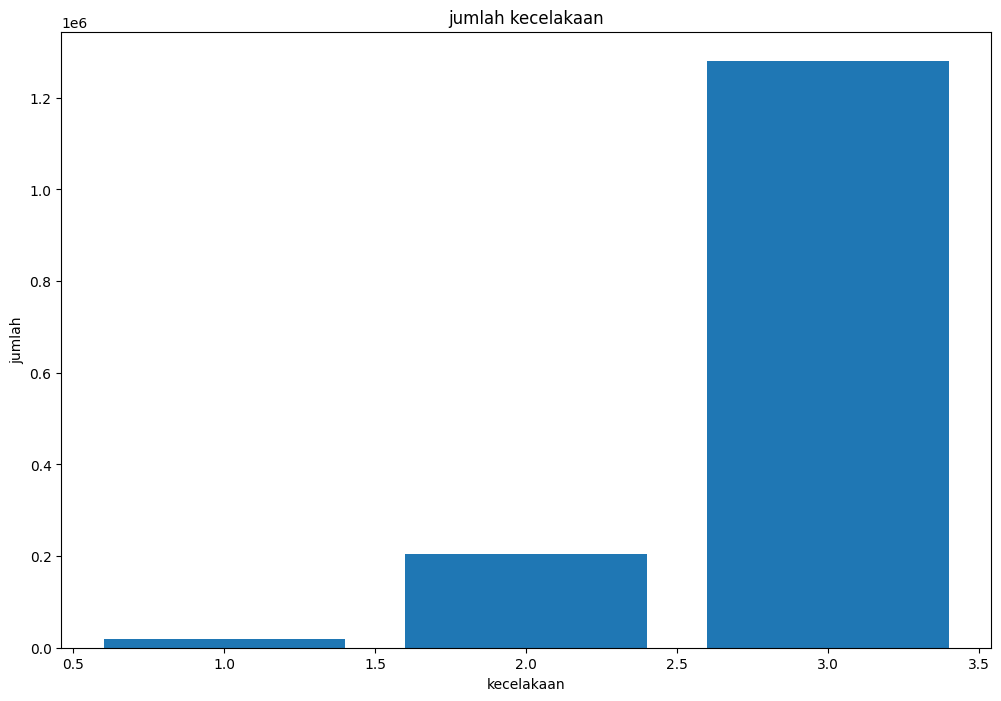

In [44]:
import matplotlib.pyplot as plt

accident_count = df.groupBy("Accident_severity").count().orderBy("count", ascending=False)
pdf = accident_count.toPandas()

plt.figure(figsize=(12, 8))
plt.bar(pdf["Accident_severity"],pdf["count"])
plt.title("jumlah kecelakaan")
plt.xlabel("kecelakaan")
plt.ylabel("jumlah")
plt.show()